# Predicting Breast Cancer With Multiple Classification Algorithms

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import eli5



## Introduction

*Background* 

*Question* 

*Dataset Description*
1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10
11. Class: (2 for benign, 4 for malignant)

*Data sources*

https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29


## EDA

*Reading the data into Notebook* 

Since the dataset did not come with column headers, we will first manually add them. The headers will correspond to the order of their respective description above.

In [2]:
col_names = ["id", "clump", "unif_size", "unif_shape", "adhesion", "epi_size",
             "nuclei", "chromatin", "nucleoli", "mitoses", "class"]

dataset = pd.read_csv("data/breast_cancer.txt", names=col_names, sep=",")

In [3]:
dataset.head()

,id,clump,unif_size,unif_shape,adhesion,epi_size,nuclei,chromatin,nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          699 non-null    int64 
 1   clump       699 non-null    int64 
 2   unif_size   699 non-null    int64 
 3   unif_shape  699 non-null    int64 
 4   adhesion    699 non-null    int64 
 5   epi_size    699 non-null    int64 
 6   nuclei      699 non-null    object
 7   chromatin   699 non-null    int64 
 8   nucleoli    699 non-null    int64 
 9   mitoses     699 non-null    int64 
 10  class       699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


We see that the dataset uses "?" for missing data so we eliminate rows that contain "?". Above all of the variables are numeric except for variables nuclei, we decide to transform it into int64 for ease of data analysis later on. Finally, "id" feature does not appear to be useful for the prediction task; hence, it is decided to be dropped before carrying on to further analysis. 

In [5]:
dataset = dataset[(dataset != '?').all(axis=1)]
dataset['nuclei'] = dataset['nuclei'].astype(int)
dataset = dataset.drop(columns=["id"])

We also decide to replace benign class from 2 to 0 and malignant class from 4 to 1 since if we keep values of 2 and 4, it would be hard for predictive models to calculate accuracy, precision, and so on. 

In [6]:
dataset['class'] = dataset['class'].replace([2],0)
dataset['class'] = dataset['class'].replace([4],1) 
dataset['class'].value_counts(normalize = True)
  

0    0.650073
1    0.349927
Name: class, dtype: float64

There is an imbalance in the dataset between benign and malignant. We want to further investigate the malignant examples (class = 4); hence the classes should have same importance so recall would be the most appropriate metric for this project.

Then we split the data into training and testing sets (X_train, X_test, y_train, y_test) for further exploration. 
 

In [7]:
train_df, test_df = train_test_split(dataset, test_size=0.3, random_state=123)
X_train = train_df.drop(columns=["class"])
X_test = test_df.drop(columns=["class"])

y_train = train_df["class"]
y_test = test_df["class"]
numeric_looking_columns = X_train.select_dtypes(include=np.number).columns.tolist()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 696 to 525
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   clump       478 non-null    int64
 1   unif_size   478 non-null    int64
 2   unif_shape  478 non-null    int64
 3   adhesion    478 non-null    int64
 4   epi_size    478 non-null    int64
 5   nuclei      478 non-null    int64
 6   chromatin   478 non-null    int64
 7   nucleoli    478 non-null    int64
 8   mitoses     478 non-null    int64
 9   class       478 non-null    int64
dtypes: int64(10)
memory usage: 41.1 KB


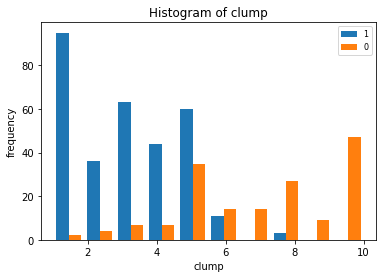

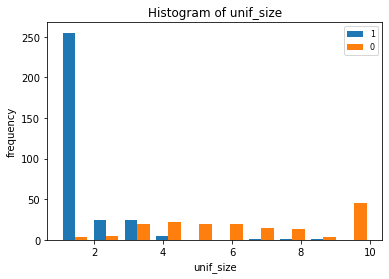

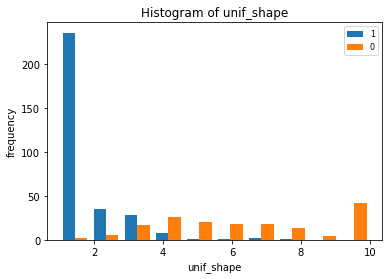

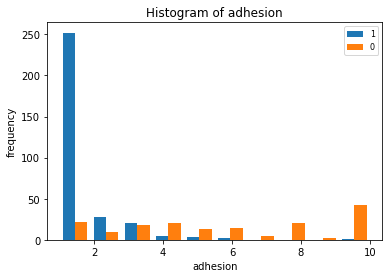

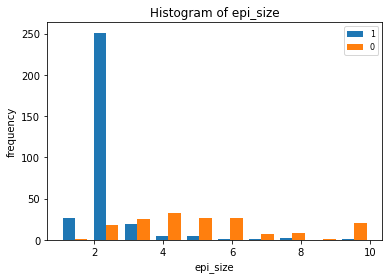

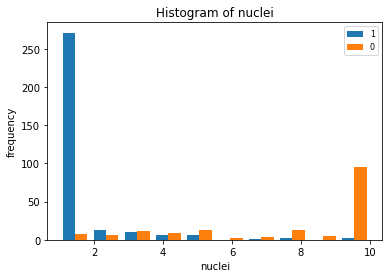

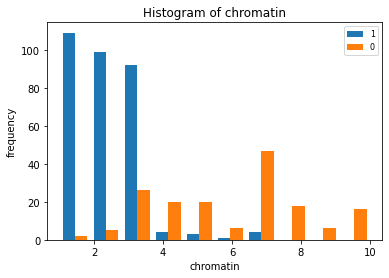

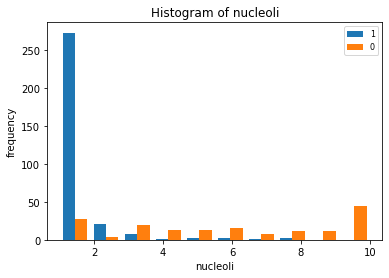

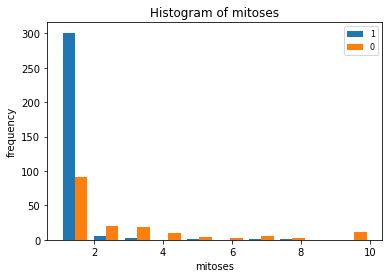

In [8]:
benign_cases = train_df[train_df["class"] == 0]
                    
malignant_cases = train_df[train_df["class"] == 1]

def plots(): 
    for x in numeric_looking_columns:
        x1 = benign_cases[x]
        y1 = malignant_cases[x]
        plt.hist([x1, y1], label=['1', '0'])
        plt.title('Histogram of ' + x)
        plt.xlabel(x)
        plt.ylabel('frequency')
        plt.legend(loc='upper right', fontsize = 8)
        plt.show()

plots()

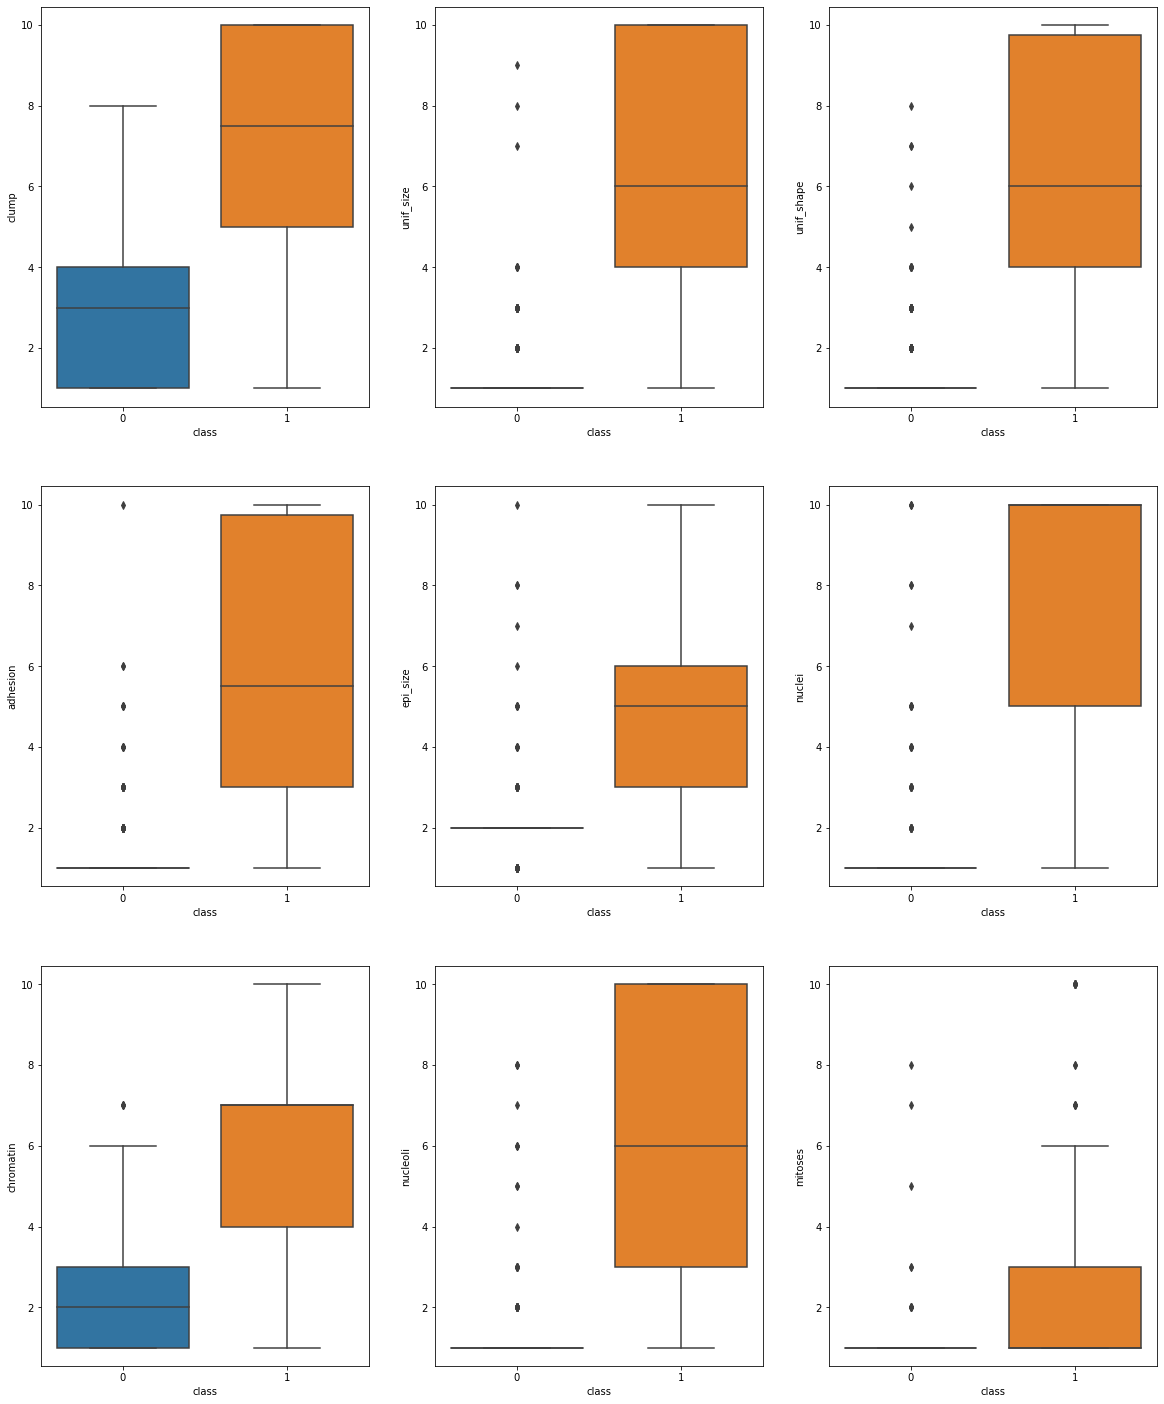

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(20, 25))
for var, subplot in zip(numeric_looking_columns, ax.flatten()):
    sns.boxplot(x='class', y=var, data=train_df, ax=subplot)

*Comments on above plots:*





## Preprocessing 

In [10]:
numeric_transformer = StandardScaler()
ct = make_column_transformer(
    (numeric_transformer, numeric_looking_columns))

## Data analysis 

In [11]:
scoring = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]

In [12]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [22]:
pipe_dt = make_pipeline(ct, DecisionTreeClassifier(random_state=123))
pipe_rf = make_pipeline(ct, RandomForestClassifier(random_state=123))
pipe_lgbm = make_pipeline(ct, LGBMClassifier(random_state=123))
pipe_catboost = make_pipeline(
    # silent=True since catboost output a lot of stuffs
    # allow_writing_files=False since we dont really use the catboost_info generated files
    ct, CatBoostClassifier(silent=True, allow_writing_files=False, random_state=123)
)
pipe_reg = make_pipeline(ct,LogisticRegression(max_iter=100000))

classifiers = {
    "Decision Tree": pipe_dt,
    "Random Forest": pipe_rf,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
    "Logistic Regression" : pipe_reg
}

results = {}

for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring = scoring 
    )
    

pd.DataFrame(results).T  

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
Decision Tree,0.005 (+/- 0.003),0.004 (+/- 0.001),0.952 (+/- 0.016),1.000 (+/- 0.000),0.930 (+/- 0.023),1.000 (+/- 0.000),0.927 (+/- 0.041),1.000 (+/- 0.000),0.935 (+/- 0.034),1.000 (+/- 0.000)
Random Forest,0.069 (+/- 0.001),0.007 (+/- 0.000),0.971 (+/- 0.005),1.000 (+/- 0.000),0.958 (+/- 0.006),1.000 (+/- 0.000),0.970 (+/- 0.000),1.000 (+/- 0.000),0.947 (+/- 0.013),1.000 (+/- 0.000)
LightGBM,0.030 (+/- 0.002),0.003 (+/- 0.001),0.969 (+/- 0.013),1.000 (+/- 0.000),0.956 (+/- 0.017),1.000 (+/- 0.000),0.976 (+/- 0.025),1.000 (+/- 0.000),0.938 (+/- 0.028),1.000 (+/- 0.000)
CatBoost,0.376 (+/- 0.009),0.003 (+/- 0.001),0.969 (+/- 0.007),1.000 (+/- 0.000),0.956 (+/- 0.010),1.000 (+/- 0.000),0.970 (+/- 0.000),1.000 (+/- 0.000),0.942 (+/- 0.019),1.000 (+/- 0.000)
Logistic Regression,0.004 (+/- 0.000),0.002 (+/- 0.000),0.964 (+/- 0.009),0.967 (+/- 0.005),0.949 (+/- 0.014),0.952 (+/- 0.007),0.946 (+/- 0.026),0.949 (+/- 0.010),0.952 (+/- 0.016),0.955 (+/- 0.005)


*Tuning hyperparameters*

In [21]:
rs_params = {
        'lgbmclassifier__max_depth': (5, 30, 1),
        'lgbmclassifier__min_data_in_leaf': (20, 120, 5),
        'lgbmclassifier__num_leaves': (1200, 1550, 5) }

search = GridSearchCV(
    pipe_lgbm, rs_params, cv=5, n_jobs=-1,  scoring="recall", return_train_score=True)

search.fit(X_train, y_train)
print(search.best_score_)
print(search.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

## Feature importance 


In [15]:
lgm = LGBMClassifier(max_depth = 5, min_data_in_leaf = 20, num_leaves = 1200, random_state=123)
pipe_lgbm = make_pipeline(ct, lgm)
pipe_lgbm.fit(X_train, y_train)
eli5.explain_weights(
    pipe_lgbm.named_steps["lgbmclassifier"], feature_names=numeric_looking_columns
)

Weight,Feature
0.3719,unif_size
0.2264,unif_shape
0.2032,nuclei
0.0470,chromatin
0.0418,clump
0.0412,nucleoli
0.0353,adhesion
0.0252,epi_size
0.0079,mitoses


## Model on test set 

In [16]:
lgm = LGBMClassifier(max_depth = 30, min_data_in_leaf = 120, num_leaves = 1200, random_state=123)
pipe_lgbm = make_pipeline(ct, lgm)
pipe_lgbm.fit(X_train, y_train) 
pipe_lgbm.score(X_test, y_test)

0.9804878048780488

## Summary of results and future analysis 

In [17]:
print(
    classification_report(
        y_test, pipe_lgbm.predict(X_test), target_names=["benign", "malignant"]
    )
)

              precision    recall  f1-score   support

      benign       0.99      0.98      0.98       132
   malignant       0.96      0.99      0.97        73

    accuracy                           0.98       205
   macro avg       0.98      0.98      0.98       205
weighted avg       0.98      0.98      0.98       205

